In [7]:
##Given a Model, find the indices that correspond to a particular scale. 
#Then, reconstruct the model at that scale. Do calculations if needed.


####SETUP
Database_Path = '../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
####################################################
depths = []
counter = 0
xcorrcoeffs = []
corrdepths = []
pvals = []
####################################################
##########
#Options to do different operations in the script.
The_Chosen_Depth = 2700
The_Chosen_Depth = 6371-The_Chosen_Depth
Scale_List = [1,2,3,4,5]
iterate_over_depths = 1
##########
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow

####More Setup for File Names
##Naming Conventions
DVBasisName = 'DVmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName = 'VWCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                        WaveletBasisFn + '.mat'
GridName= 'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
          '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
          '.EulerConfig' + str(EulerConfig) + '.mat'

####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Resid_Norm_Map = np.zeros((len(Depth_List),(len(Scale_List)-1)))

################################
###Setup the iterations over here. 



    
if iterate_over_depths == 1:
    Depth_List = np.unique(Depths)
    Depth_List = np.flip(Depth_List,0)
else:
    Depth_List = np.array([The_Chosen_Depth])
    
    
    
for iii in range(len(Depth_List)):
    Depth_Interest = Depth_List[iii]
    print(Depth_Interest)
    
    for k in range(len(Scale_List)):
        Scale_Interest = Scale_List[k:len(Scale_List)]
        print(Scale_Interest)

    ####################################
    ##Find the indices that correspond to a particular scale or set of scales. 
        for i in range(np.size(Scale_Interest)):
                Temp_Scale_Checker = np.nonzero(Grids['ScaleIndex'][0,:] == (Scale_Interest[i]))
                if i == 0:
                    Scale_Checker = Temp_Scale_Checker
                elif i > 0:
                    Scale_Checker = np.concatenate([Scale_Checker,Temp_Scale_Checker],axis=1)


        Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
        Depth_Coeffs = wvcoeffs[0,Depth_Checker]
        Depth_Coeffs = Depth_Coeffs[0]
                ##Make Maps. 
        Face1Map = 0;
        Face2Map = 0;
        Face3Map = 0;
        Face4Map = 0;
        Face5Map = 0;
        Face6Map = 0;

        for i in range(len(Scale_Checker[0])):
            Curr_Index = Scale_Checker[0][i] 
            Curr_BasisIndex = Curr_Index%(NumVals/6)

                                #    Curr_Coeff = Depth_100_Coeffs[Curr_Index]
            Curr_Coeff = Depth_Coeffs[Curr_Index]
            if Grids['face'][Curr_Index] == 1:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face1Map = Face1Map+Curr_Map*Curr_Coeff
            elif Grids['face'][Curr_Index] == 2:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face2Map = Face2Map+Curr_Map*Curr_Coeff
            elif Grids['face'][Curr_Index] == 3:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face3Map = Face3Map+Curr_Map*Curr_Coeff
            elif Grids['face'][Curr_Index] == 4:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face4Map = Face4Map+Curr_Map*Curr_Coeff
            elif Grids['face'][Curr_Index] == 5:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face5Map = Face5Map+Curr_Map*Curr_Coeff
            elif Grids['face'][Curr_Index] == 6:
                Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
                Face6Map = Face6Map+Curr_Map*Curr_Coeff

        All_map =[Face1Map,Face2Map,Face3Map,Face4Map,Face5Map,Face6Map]

    #################################### Now do some calculations, if you want. 
        if Scale_Interest == Scale_List:
            FullModelFace1 = Face1Map
            FullModelFace2 = Face2Map
            FullModelFace3 = Face3Map
            FullModelFace4 = Face4Map
            FullModelFace5 = Face5Map
            FullModelFace6 = Face6Map
        else:
            ResidFace1 = FullModelFace1-Face1Map
            ResidFace2 = FullModelFace2-Face2Map
            ResidFace3 = FullModelFace3-Face3Map
            ResidFace4 = FullModelFace4-Face4Map
            ResidFace5 = FullModelFace5-Face5Map
            ResidFace6 = FullModelFace6-Face6Map
            
            Curr_Norms = [np.linalg.norm(ResidFace1),np.linalg.norm(ResidFace2),np.linalg.norm(ResidFace3),np.linalg.norm(ResidFace4),np.linalg.norm(ResidFace5),np.linalg.norm(ResidFace6)]
            Avg_Norm = np.mean(Curr_Norms)
            Resid_Norm_Map[iii,k-1] = Avg_Norm 
            
All_Resid_map = [ResidFace1,ResidFace2,ResidFace3,ResidFace4,ResidFace5,ResidFace6] 
Orig_Map = [FullModelFace1,FullModelFace2,FullModelFace3,FullModelFace4,FullModelFace5,FullModelFace6]

6346
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
6271
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
6171
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
6071
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5971
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5871
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5771
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5671
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5571
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5471
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5371
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5271
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5171
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
5071
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
4971
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
4871
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
4771
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
4671
[1, 2, 3, 4, 5]
[2, 3, 4, 5]
[3, 4, 5]
[4, 5]
[5]
4571
[1, 2

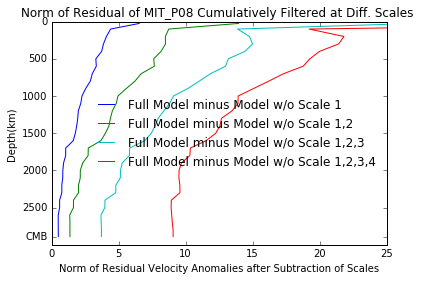

In [8]:
fig = plt.figure()
ax = plt.subplot(111)
Scale1CumResid = ax.plot(Resid_Norm_Map[:,0], 6371-Depth_List,'b-',label='Full Model minus Model w/o Scale 1')
Scale2CumResid = ax.plot(Resid_Norm_Map[:,1], 6371-Depth_List,'g-',label='Full Model minus Model w/o Scale 1,2')
Scale3CumResid = ax.plot(Resid_Norm_Map[:,2], 6371-Depth_List,'c-',label='Full Model minus Model w/o Scale 1,2,3')
Scale4CumResid = ax.plot(Resid_Norm_Map[:,3], 6371-Depth_List,'r-',label='Full Model minus Model w/o Scale 1,2,3,4')



ax.set_ylabel('Depth(km)')
ax.set_xlabel('Norm of Residual Velocity Anomalies after Subtraction of Scales')
ax.set_title('Norm of Residual of ' + ModelName + ' Cumulatively Filtered at Diff. Scales ')
plt.gca().invert_yaxis()
plt.xlim(0, 25)

CMB = [0, 500, 1000, 1500, 2000, 2500, 2891]
y_ticks_labels = ['0','500','1000','1500','2000','2500','CMB']
    # Set number of ticks for x-axis
ax.set_yticks(CMB)
    # Set ticks labels for x-axis
ax.set_yticklabels(y_ticks_labels, rotation='horizontal')
    #plt.legend([Scale1,Scale2,Scale3,Scale4,Scaling_Function,Model_Norm],['Scale 1','Scale 2','Scale 3','Scale 4','Scaling Function','Model'])
plt.legend(frameon=False,loc=5)
plt.show()

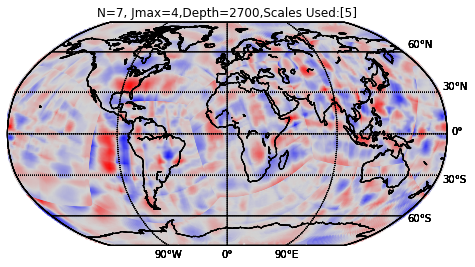

In [5]:
#####Make Plots!

All_map = All_Resid_map

Nbasis = len(WaveletBasis['Me'][0,:])
fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='w')

ax = fig.add_subplot(111)
for i in range(len(All_map)):
#Plot a wavelet from a selected face
    #print(i)
    face = i
    value = All_map[i]
    value = np.transpose(value)
    value = value.flatten()

    N = Grids['MetaN'][0][0]
    ScaleIndex = Grids['ScaleIndex'][0][0]
    #print ScaleIndex
    Jmax = Grids['MetaJmax'][0][0]
    lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
    latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]


    # Define a colorscale
    colormax=np.amax(abs(value)) #(-colormax,colormax) are the limits of the colorbar
    greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
    name='r_lgrey_b'
    c = colors.ColorConverter().to_rgb
    colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
    custom_cmap = make_colormap(colorlist,name)
    register_cmap(name=custom_cmap.name, cmap=custom_cmap)
    palette=custom_cmap.name

    colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
    #print colorVal.shape,value.shape,lonwav.shape
    
    
    # Make the figure

    m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
    m.drawcoastlines()
    x, y = m(lonwav,latwav); 
    cm = get_cmap(palette)
    sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)

    # Set title

    titlestr='N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371 - Depth_Interest)+',Scales Used:'+str(Scale_Interest)#'+str(face+1),
    ax.set_title(titlestr,fontsize=12)

    # draw parallels and meridians.
    # labels = [left,right,top,bottom]
    parallels = np.arange(-60,90,30.)
    m.drawparallels(parallels,labels=[False,True,False,False])
    meridians = np.arange(0.,360.,90.)
    m.drawmeridians(meridians,labels=[False,False,False,True])
